# 03 — Network Analysis: Correlation Graphs, Centrality & Communities

**Goal**: Build correlation-based networks for the full period and each crisis event.  
Compute centrality measures to identify which assets act as "bridges" between crypto and TradFi,  
and use Louvain community detection to see whether the two worlds merge during crises.

**Pipeline**:  
correlation matrix → threshold (|ρ| > 0.3) → adjacency matrix → graph → centrality + communities

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain  # python-louvain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from scipy.spatial import ConvexHull
from pathlib import Path

plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 10,
})

DATA_DIR = Path('..') / 'data'

## 1. Load Data & Define Asset Groups

In [2]:
returns = pd.read_csv(DATA_DIR / 'returns.csv', index_col='Date', parse_dates=True)
events = pd.read_csv(DATA_DIR / 'events.csv', index_col=0, parse_dates=['start', 'end'])

TRADFI = ['Gold', 'NASDAQ 100', 'S&P 500', 'US Treasury 20Y+', 'US Dollar Index', 'VIX']
CRYPTO = ['Aave (DeFi proxy)', 'BNB', 'Bitcoin', 'Ethereum', 'Solana']

# Keep only columns present in data
TRADFI = [c for c in TRADFI if c in returns.columns]
CRYPTO = [c for c in CRYPTO if c in returns.columns]
ALL_ASSETS = TRADFI + CRYPTO

# Short labels for graph nodes (full names are too long)
SHORT_LABELS = {
    'Gold': 'Gold',
    'NASDAQ 100': 'NDX',
    'S&P 500': 'SPX',
    'US Treasury 20Y+': 'TLT',
    'US Dollar Index': 'USD',
    'VIX': 'VIX',
    'Aave (DeFi proxy)': 'AAVE',
    'BNB': 'BNB',
    'Bitcoin': 'BTC',
    'Ethereum': 'ETH',
    'Solana': 'SOL',
}

print(f'Loaded {len(returns)} trading days, {len(ALL_ASSETS)} assets')
print(f'Events: {list(events.index)}')

Loaded 1529 trading days, 11 assets
Events: ['COVID Crash', 'China Crypto Ban', 'Luna/Terra Collapse', 'FTX Collapse', 'SVB Crisis', 'BTC ETF Approval']


## 2. Core Functions: Correlation → Graph → Metrics

Each function does one thing. The pipeline is:
1. `get_valid_returns()` — filter assets with enough data
2. `corr_to_graph()` — correlation matrix → networkx Graph with threshold
3. `compute_graph_metrics()` — centrality, density, communities

In [3]:
def get_valid_returns(returns_df, assets, start=None, end=None, min_obs=10):
    """
    Slice returns to a date window and keep only assets with >= min_obs
    non-NaN observations.
    
    Parameters
    ----------
    returns_df : pd.DataFrame
    assets : list of str
    start, end : str or None
        If None, use the full period.
    min_obs : int
        Minimum non-NaN observations required.
    
    Returns
    -------
    valid_returns : pd.DataFrame
        Filtered returns.
    valid_assets : list of str
        Assets that passed the filter.
    excluded : list of str
        Assets removed due to insufficient data.
    """
    if start is not None and end is not None:
        subset = returns_df.loc[start:end, assets]
    else:
        subset = returns_df[assets]
    
    counts = subset.count()
    valid_assets = counts[counts >= min_obs].index.tolist()
    excluded = [a for a in assets if a not in valid_assets]
    
    return subset[valid_assets], valid_assets, excluded


def corr_to_graph(corr_matrix, threshold=0.3):
    """
    Convert a correlation matrix to an undirected networkx Graph.
    
    An edge exists between nodes i and j if |corr(i,j)| > threshold.
    Edge weight = |corr(i,j)| (always positive — we care about 
    strength of dependence, not its sign).
    Edge attribute 'raw_corr' stores the original signed correlation
    for reference.
    
    Parameters
    ----------
    corr_matrix : pd.DataFrame
        Square correlation matrix.
    threshold : float
        Minimum |correlation| to create an edge.
    
    Returns
    -------
    G : nx.Graph
    """
    G = nx.Graph()
    assets = corr_matrix.columns.tolist()
    G.add_nodes_from(assets)
    
    for i in range(len(assets)):
        for j in range(i + 1, len(assets)):
            rho = corr_matrix.iloc[i, j]
            if not np.isnan(rho) and abs(rho) > threshold:
                G.add_edge(assets[i], assets[j],
                           weight=abs(rho),
                           raw_corr=rho)
    
    return G


def compute_graph_metrics(G):
    """
    Compute centrality measures and community structure for a graph.
    
    Returns
    -------
    metrics : dict with keys:
        'degree_centrality' : dict {node: value}
        'betweenness_centrality' : dict {node: value}
        'communities' : dict {node: community_id}
        'density' : float
        'n_communities' : int
        'avg_degree' : float
        'top_betweenness_node' : str  (the "bridge" node)
    """
    deg_cent = nx.degree_centrality(G)
    bet_cent = nx.betweenness_centrality(G, weight='weight')
    
    # Louvain community detection
    # Uses weight = |correlation| so strongly correlated nodes cluster together
    if G.number_of_edges() > 0:
        communities = community_louvain.best_partition(G, weight='weight',
                                                       random_state=42)
    else:
        # No edges: each node is its own community
        communities = {node: i for i, node in enumerate(G.nodes())}
    
    density = nx.density(G)
    n_communities = len(set(communities.values()))
    
    # Average degree: sum of all degrees / number of nodes
    degrees = dict(G.degree())
    avg_degree = np.mean(list(degrees.values())) if degrees else 0.0
    
    # Node with highest betweenness (the main "bridge")
    if bet_cent:
        top_node = max(bet_cent, key=bet_cent.get)
    else:
        top_node = None
    
    return {
        'degree_centrality': deg_cent,
        'betweenness_centrality': bet_cent,
        'communities': communities,
        'density': density,
        'n_communities': n_communities,
        'avg_degree': avg_degree,
        'top_betweenness_node': top_node,
    }


print('Functions defined: get_valid_returns, corr_to_graph, compute_graph_metrics')

Functions defined: get_valid_returns, corr_to_graph, compute_graph_metrics


## 3. Build Graphs for All Periods

Build one graph per period: full baseline + 6 crisis events.

In [4]:
THRESHOLD = 0.3

# Container for all results: list of dicts
# Each dict: {name, G, metrics, valid_assets, excluded}
all_graphs = []

# --- Baseline (full period) ---
valid_ret, valid_assets, excluded = get_valid_returns(returns, ALL_ASSETS)
corr_mat = valid_ret.corr()
G_baseline = corr_to_graph(corr_mat, threshold=THRESHOLD)
m_baseline = compute_graph_metrics(G_baseline)

all_graphs.append({
    'name': 'Baseline (Full Period)',
    'G': G_baseline,
    'metrics': m_baseline,
    'valid_assets': valid_assets,
    'excluded': excluded,
})
print(f'Baseline: {G_baseline.number_of_nodes()} nodes, '
      f'{G_baseline.number_of_edges()} edges, '
      f'density={m_baseline["density"]:.3f}')

# --- Each crisis event ---
for event_name, row in events.iterrows():
    valid_ret, valid_assets, excluded = get_valid_returns(
        returns, ALL_ASSETS, start=row['start'], end=row['end']
    )
    corr_mat = valid_ret.corr()
    G_event = corr_to_graph(corr_mat, threshold=THRESHOLD)
    m_event = compute_graph_metrics(G_event)
    
    all_graphs.append({
        'name': event_name,
        'G': G_event,
        'metrics': m_event,
        'valid_assets': valid_assets,
        'excluded': excluded,
    })
    excl_str = f' (excl: {", ".join(excluded)})' if excluded else ''
    print(f'{event_name}: {G_event.number_of_nodes()} nodes, '
          f'{G_event.number_of_edges()} edges, '
          f'density={m_event["density"]:.3f}{excl_str}')

print(f'\nBuilt {len(all_graphs)} graphs (threshold |ρ| > {THRESHOLD})')

Baseline: 11 nodes, 16 edges, density=0.291
COVID Crash: 9 nodes, 24 edges, density=0.667 (excl: Aave (DeFi proxy), Solana)
China Crypto Ban: 11 nodes, 22 edges, density=0.400
Luna/Terra Collapse: 11 nodes, 44 edges, density=0.800
FTX Collapse: 11 nodes, 47 edges, density=0.855
SVB Crisis: 11 nodes, 22 edges, density=0.400
BTC ETF Approval: 11 nodes, 22 edges, density=0.400

Built 7 graphs (threshold |ρ| > 0.3)


## 4. Visualization: 7-Panel Network Figure

Layout conventions:
- **Node color**: blue = TradFi, orange = Crypto
- **Node size** ∝ degree centrality
- **Edge width** ∝ |correlation|
- **Dashed contour** around Louvain communities
- Title shows event name + graph density

In [5]:
def draw_community_hulls(ax, G, pos, communities, alpha=0.10):
    """
    Draw a shaded convex hull around each Louvain community.
    
    Uses ConvexHull for communities with >= 3 nodes,
    a circle for 2 nodes, and nothing for singletons.
    """
    # Group nodes by community
    comm_groups = {}
    for node, comm_id in communities.items():
        if node in pos:  # only nodes actually in graph layout
            comm_groups.setdefault(comm_id, []).append(node)
    
    # Color palette for communities
    palette = plt.cm.Set3(np.linspace(0, 1, max(len(comm_groups), 1)))
    
    for idx, (comm_id, nodes) in enumerate(sorted(comm_groups.items())):
        if len(nodes) < 2:
            continue  # no hull for single nodes
        
        points = np.array([pos[n] for n in nodes])
        color = palette[idx % len(palette)]
        
        if len(nodes) == 2:
            # Draw an ellipse around 2 nodes
            center = points.mean(axis=0)
            circle = plt.Circle(center, radius=0.15, 
                                fill=True, facecolor=color, 
                                edgecolor='gray', linewidth=1.5,
                                linestyle='--', alpha=alpha, zorder=0)
            ax.add_patch(circle)
        else:
            # Convex hull with padding
            try:
                hull = ConvexHull(points)
                hull_points = points[hull.vertices]
                
                # Expand hull outward slightly for visual padding
                centroid = hull_points.mean(axis=0)
                expanded = centroid + 1.25 * (hull_points - centroid)
                
                polygon = plt.Polygon(expanded, closed=True,
                                      facecolor=color, edgecolor='gray',
                                      linewidth=1.5, linestyle='--',
                                      alpha=alpha, zorder=0)
                ax.add_patch(polygon)
            except Exception:
                # Degenerate hull (collinear points) — skip
                pass


def draw_network(ax, G, metrics, title, tradfi_list, crypto_list, short_labels):
    """
    Draw a single network graph on the given axes.
    
    Parameters
    ----------
    ax : matplotlib Axes
    G : nx.Graph
    metrics : dict from compute_graph_metrics()
    title : str
    tradfi_list, crypto_list : lists of asset names
    short_labels : dict {full_name: short_name}
    """
    if G.number_of_nodes() == 0:
        ax.set_title(title)
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
        return
    
    # --- Layout ---
    # Use spring layout with seed for reproducibility.
    # weight parameter makes strongly correlated nodes cluster.
    pos = nx.spring_layout(G, k=1.8, iterations=80, seed=42, weight='weight')
    
    # --- Community hulls (drawn first, behind everything) ---
    draw_community_hulls(ax, G, pos, metrics['communities'], alpha=0.15)
    
    # --- Node colors: blue=TradFi, orange=Crypto ---
    node_colors = []
    for node in G.nodes():
        if node in tradfi_list:
            node_colors.append('#4A90D9')  # blue
        else:
            node_colors.append('#E8873A')  # orange
    
    # --- Node sizes: proportional to degree centrality ---
    deg_cent = metrics['degree_centrality']
    min_size, max_size = 300, 1800
    node_sizes = []
    for node in G.nodes():
        dc = deg_cent.get(node, 0)
        # scale: 0 -> min_size, 1 -> max_size
        node_sizes.append(min_size + dc * (max_size - min_size))
    
    # --- Edge widths: proportional to |correlation| ---
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    if edge_weights:
        min_w, max_w = min(edge_weights), max(edge_weights)
        if max_w > min_w:
            edge_widths = [0.5 + 4.0 * (w - min_w) / (max_w - min_w) for w in edge_weights]
        else:
            edge_widths = [2.0] * len(edge_weights)
    else:
        edge_widths = []
    
    # --- Edge colors: blue=positive corr, red=negative ---
    edge_colors = []
    for u, v in G.edges():
        raw = G[u][v]['raw_corr']
        if raw >= 0:
            edge_colors.append('#666666')  # positive: dark gray
        else:
            edge_colors.append('#CC4444')  # negative: red
    
    # --- Draw ---
    nx.draw_networkx_edges(G, pos, ax=ax,
                           width=edge_widths,
                           edge_color=edge_colors,
                           alpha=0.6)
    
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_color=node_colors,
                           node_size=node_sizes,
                           edgecolors='black',
                           linewidths=0.8,
                           alpha=0.9)
    
    # --- Labels (use short names) ---
    labels = {n: short_labels.get(n, n) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax,
                            font_size=8, font_weight='bold')
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')


print('Visualization functions defined')

Visualization functions defined


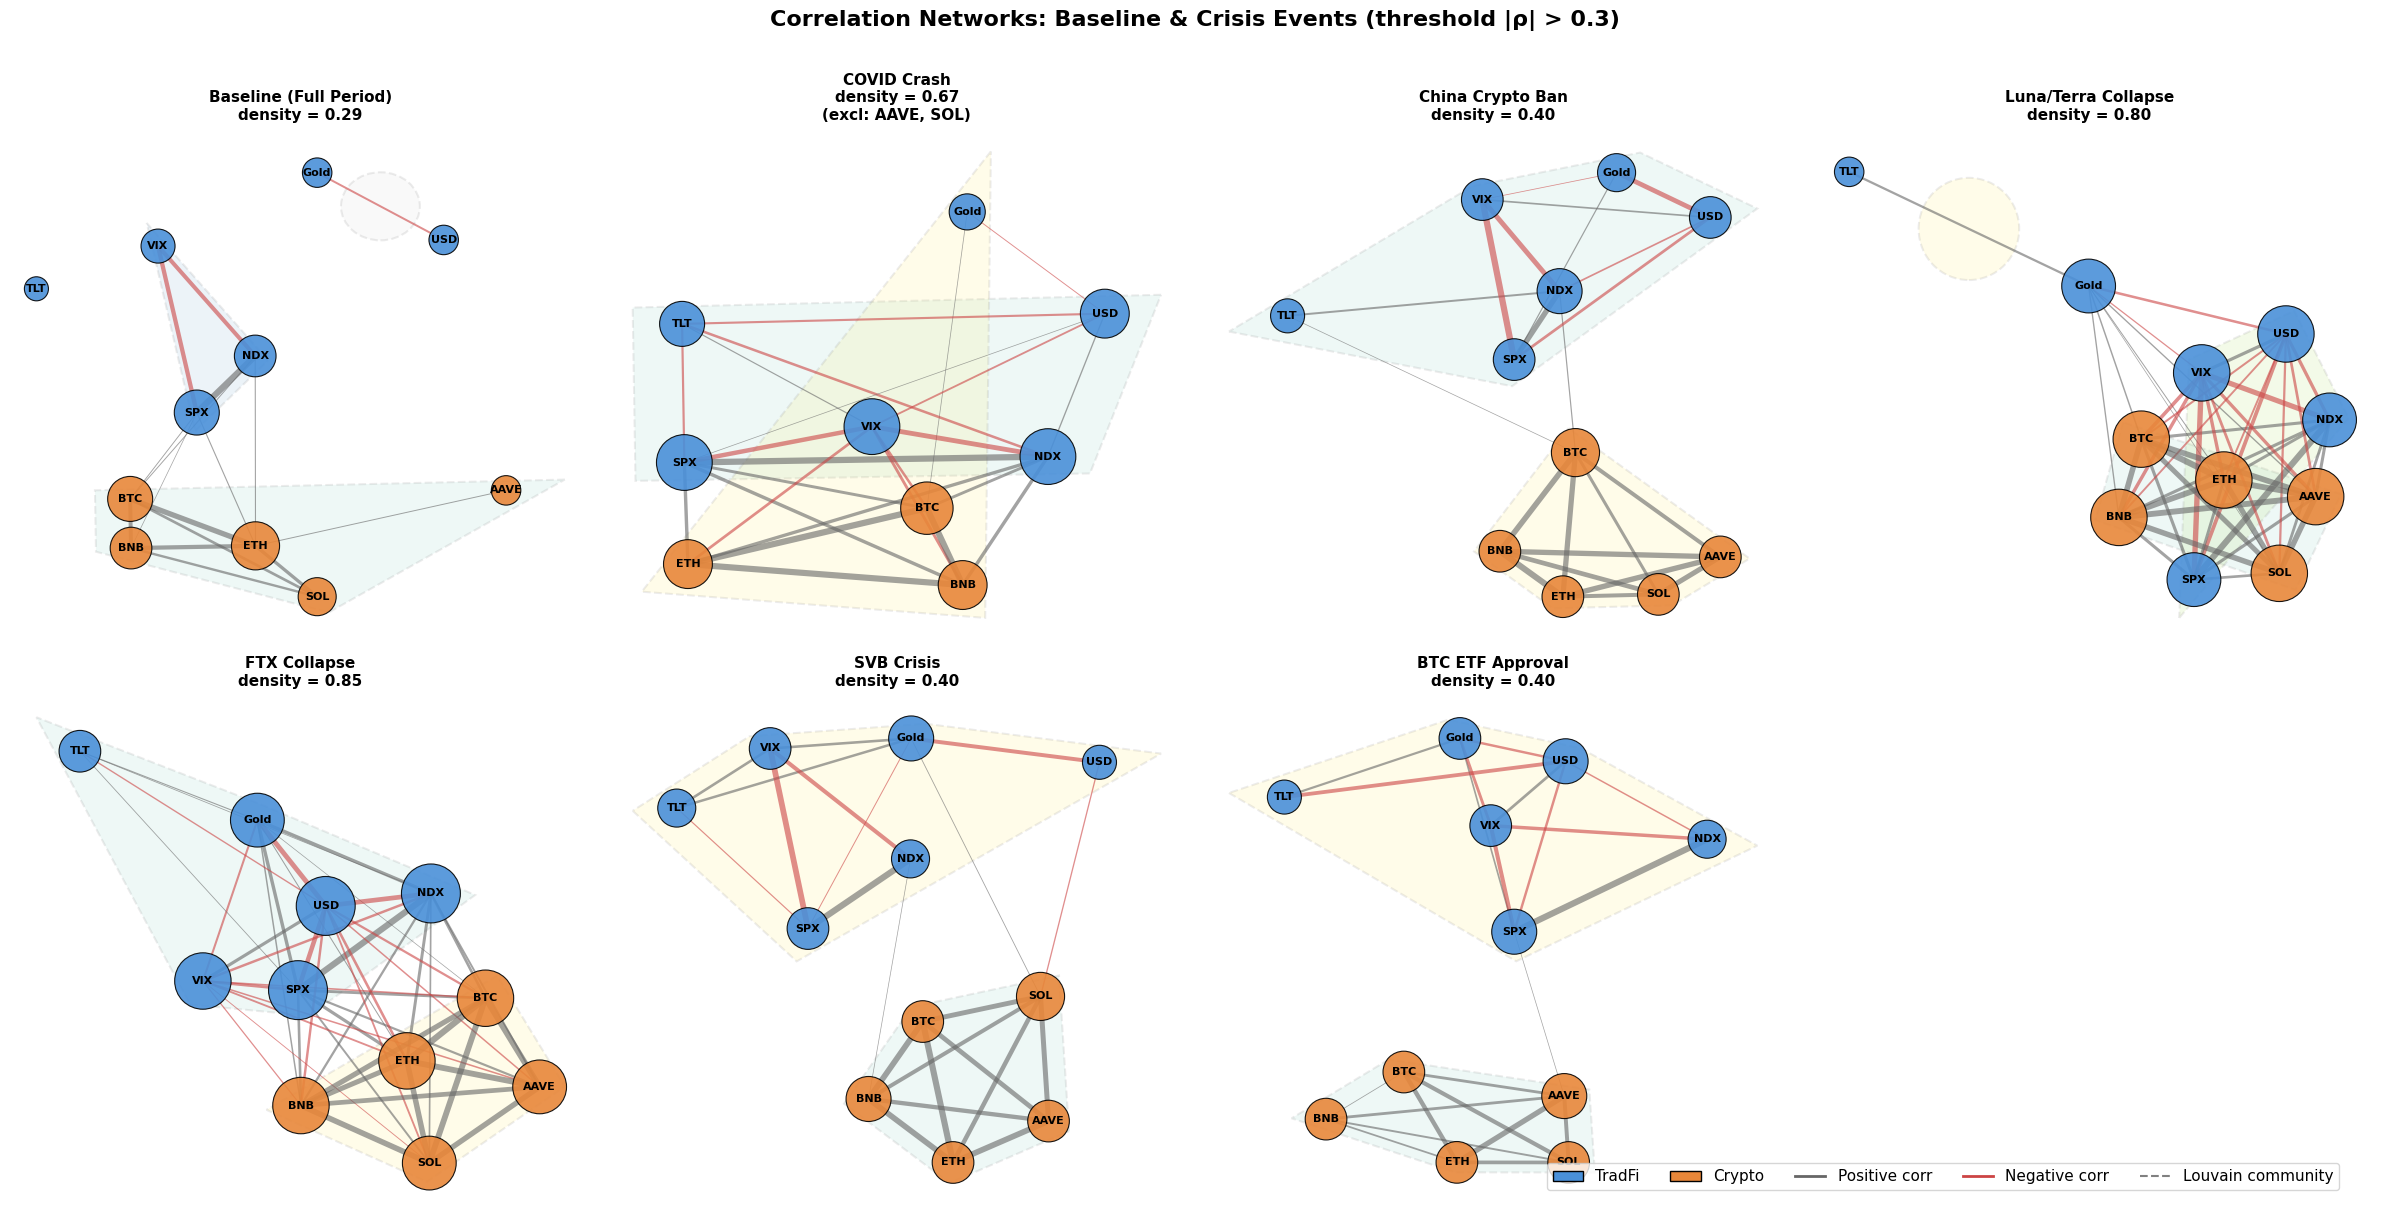

Saved figure to ../data/network_graphs.png


In [6]:
# ====================================================================
# Main figure: 7 panels (baseline + 6 events)
# Layout: 2 rows x 4 cols, first cell = baseline (slightly larger feel)
# ====================================================================

n_panels = len(all_graphs)  # 7
n_cols = 4
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))
axes = axes.flatten()

for idx, gdata in enumerate(all_graphs):
    ax = axes[idx]
    name = gdata['name']
    G = gdata['G']
    m = gdata['metrics']
    excluded = gdata['excluded']
    
    # Build title with density
    title = f"{name}\ndensity = {m['density']:.2f}"
    if excluded:
        title += f"\n(excl: {', '.join([SHORT_LABELS.get(e, e) for e in excluded])})"
    
    draw_network(ax, G, m, title, TRADFI, CRYPTO, SHORT_LABELS)

# Hide unused subplot
for idx in range(n_panels, len(axes)):
    axes[idx].set_visible(False)

# Legend
legend_elements = [
    mpatches.Patch(facecolor='#4A90D9', edgecolor='black', label='TradFi'),
    mpatches.Patch(facecolor='#E8873A', edgecolor='black', label='Crypto'),
    plt.Line2D([0], [0], color='#666666', linewidth=2, label='Positive corr'),
    plt.Line2D([0], [0], color='#CC4444', linewidth=2, label='Negative corr'),
    plt.Line2D([0], [0], color='gray', linewidth=1.5, linestyle='--', label='Louvain community'),
]
fig.legend(handles=legend_elements, loc='lower right', 
           fontsize=11, frameon=True, ncol=5,
           bbox_to_anchor=(0.98, 0.02))

fig.suptitle(f'Correlation Networks: Baseline & Crisis Events (threshold |ρ| > {THRESHOLD})',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(DATA_DIR / 'network_graphs.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved figure to {DATA_DIR / "network_graphs.png"}')

## 5. Summary Table

For each period: graph density, number of Louvain communities, average degree, and the node with the highest betweenness centrality (the main "bridge" between market clusters).

In [7]:
def build_summary_table(all_graphs, short_labels):
    """
    Build a summary DataFrame from the list of graph results.
    
    Columns:
    - density: fraction of possible edges that exist
    - n_communities: number of Louvain communities
    - avg_degree: average node degree
    - top_bridge: node with highest betweenness centrality
    - top_bridge_score: its betweenness score
    - n_nodes / n_edges: graph size
    """
    rows = []
    for gdata in all_graphs:
        m = gdata['metrics']
        G = gdata['G']
        top_node = m['top_betweenness_node']
        top_score = m['betweenness_centrality'].get(top_node, 0) if top_node else 0
        top_label = short_labels.get(top_node, top_node) if top_node else '—'
        
        rows.append({
            'Period': gdata['name'],
            'Nodes': G.number_of_nodes(),
            'Edges': G.number_of_edges(),
            'Density': round(m['density'], 3),
            'Communities': m['n_communities'],
            'Avg Degree': round(m['avg_degree'], 2),
            'Top Bridge': top_label,
            'Betweenness': round(top_score, 3),
        })
    
    return pd.DataFrame(rows).set_index('Period')


summary = build_summary_table(all_graphs, SHORT_LABELS)
display(summary)

,Nodes,Edges,Density,Communities,Avg Degree,Top Bridge,Betweenness
Period,,,,,,,
Baseline (Full Period),11,16,0.291,4,2.91,SPX,0.178
COVID Crash,9,24,0.667,2,5.33,USD,0.286
China Crypto Ban,11,22,0.400,2,4.00,NDX,0.533
Luna/Terra Collapse,11,44,0.800,3,8.00,Gold,0.422
FTX Collapse,11,47,0.855,2,8.55,VIX,0.178
SVB Crisis,11,22,0.400,2,4.00,SOL,0.422
BTC ETF Approval,11,22,0.400,2,4.00,SPX,0.556


## 6. Detailed Centrality Table

Degree and betweenness centrality for every node in every period, so we can track how individual assets change roles across crises.

In [8]:
def build_centrality_detail(all_graphs, short_labels):
    """
    Build a multi-column DataFrame: rows = assets, columns = periods.
    Shows (degree_centrality, betweenness_centrality, community_id) per cell.
    """
    # Collect degree centrality across periods
    deg_data = {}
    bet_data = {}
    comm_data = {}
    
    for gdata in all_graphs:
        name = gdata['name']
        m = gdata['metrics']
        
        deg_data[name] = {short_labels.get(k, k): round(v, 3)
                          for k, v in m['degree_centrality'].items()}
        bet_data[name] = {short_labels.get(k, k): round(v, 3)
                          for k, v in m['betweenness_centrality'].items()}
        comm_data[name] = {short_labels.get(k, k): v
                           for k, v in m['communities'].items()}
    
    deg_df = pd.DataFrame(deg_data).T
    bet_df = pd.DataFrame(bet_data).T
    
    print('=== Degree Centrality ===')
    display(deg_df)
    print()
    print('=== Betweenness Centrality ===')
    display(bet_df)
    
    return deg_df, bet_df


deg_df, bet_df = build_centrality_detail(all_graphs, SHORT_LABELS)

=== Degree Centrality ===


,Gold,NDX,SPX,TLT,USD,VIX,AAVE,BNB,BTC,ETH,SOL
Baseline (Full Period),0.10,0.400,0.500,0.0,0.100,0.200,0.1,0.400,0.50,0.600,0.3
COVID Crash,0.25,0.875,0.875,0.5,0.625,0.875,NaN,0.625,0.75,0.625,NaN
China Crypto Ban,0.30,0.500,0.400,0.2,0.400,0.400,0.4,0.400,0.60,0.400,0.4
Luna/Terra Collapse,0.80,0.800,0.800,0.1,0.900,0.900,0.9,0.900,0.90,0.900,0.9
FTX Collapse,0.80,1.000,1.000,0.4,1.000,0.900,0.8,0.900,0.90,0.900,0.8
SVB Crisis,0.50,0.300,0.400,0.3,0.200,0.400,0.4,0.500,0.40,0.400,0.6
BTC ETF Approval,0.40,0.300,0.500,0.2,0.500,0.400,0.5,0.400,0.40,0.400,0.4



=== Betweenness Centrality ===


,Gold,NDX,SPX,TLT,USD,VIX,AAVE,BNB,BTC,ETH,SOL
Baseline (Full Period),0.000,0.067,0.178,0.000,0.000,0.000,0.000,0.044,0.067,0.133,0.000
COVID Crash,0.036,0.000,0.143,0.000,0.286,0.107,NaN,0.000,0.000,0.000,NaN
China Crypto Ban,0.022,0.533,0.000,0.000,0.000,0.156,0.000,0.000,0.533,0.000,0.000
Luna/Terra Collapse,0.422,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.089
FTX Collapse,0.156,0.044,0.000,0.089,0.000,0.178,0.000,0.000,0.000,0.000,0.000
SVB Crisis,0.356,0.044,0.000,0.000,0.000,0.044,0.000,0.111,0.000,0.000,0.422
BTC ETF Approval,0.156,0.000,0.556,0.000,0.178,0.000,0.533,0.000,0.000,0.000,0.000


## 7. Community Membership Across Crises

Key question: do crypto and TradFi assets end up in the **same** community during crises? If yes → contagion hypothesis supported.

In [9]:
def analyze_community_mixing(all_graphs, tradfi_list, crypto_list, short_labels):
    """
    For each period, check if TradFi and Crypto assets share communities.
    
    A "mixed" community contains at least one TradFi and one Crypto asset.
    More mixed communities → stronger contagion signal.
    """
    rows = []
    
    for gdata in all_graphs:
        name = gdata['name']
        communities = gdata['metrics']['communities']
        
        # Group nodes by community
        comm_groups = {}
        for node, cid in communities.items():
            comm_groups.setdefault(cid, []).append(node)
        
        n_mixed = 0
        mixed_members = []
        
        for cid, members in comm_groups.items():
            has_tradfi = any(m in tradfi_list for m in members)
            has_crypto = any(m in crypto_list for m in members)
            if has_tradfi and has_crypto:
                n_mixed += 1
                labels = [short_labels.get(m, m) for m in members]
                mixed_members.append('{' + ', '.join(sorted(labels)) + '}')
        
        rows.append({
            'Period': name,
            'Total Communities': len(comm_groups),
            'Mixed Communities': n_mixed,
            'Mixed Members': ' | '.join(mixed_members) if mixed_members else '—',
        })
    
    return pd.DataFrame(rows).set_index('Period')


mixing_df = analyze_community_mixing(all_graphs, TRADFI, CRYPTO, SHORT_LABELS)
display(mixing_df)

,Total Communities,Mixed Communities,Mixed Members
Period,,,
Baseline (Full Period),4,0,—
COVID Crash,2,1,"{BNB, BTC, ETH, Gold}"
China Crypto Ban,2,0,—
Luna/Terra Collapse,3,0,—
FTX Collapse,2,0,—
SVB Crisis,2,0,—
BTC ETF Approval,2,0,—
